In [58]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools
import random
import os

In [47]:
!wget https://raw.githubusercontent.com/antisocialites/Deep-Learning/main/Assignment%201/Xtrain.mat
!wget https://raw.githubusercontent.com/antisocialites/Deep-Learning/main/Assignment%201/Xtest.mat

--2025-05-09 08:42:09--  https://raw.githubusercontent.com/antisocialites/Deep-Learning/main/Assignment%201/Xtrain.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1159 (1.1K) [application/octet-stream]
Saving to: ‘Xtrain.mat.1’

Xtrain.mat.1        100%[===================>]   1.13K  --.-KB/s    in 0s      

2025-05-09 08:42:09 (49.3 MB/s) - ‘Xtrain.mat.1’ saved [1159/1159]

--2025-05-09 08:42:09--  https://raw.githubusercontent.com/antisocialites/Deep-Learning/main/Assignment%201/Xtest.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200

In [48]:
data = scipy.io.loadmat('Xtrain.mat')
test_data = scipy.io.loadmat('Xtest.mat')
x = data['Xtrain'].flatten()  # [1000,] shape
x_test = test_data['Xtest'].flatten()  # [1000,] shape
print("Data shape:", x.shape)

# load test data

Data shape: (1000,)


### Analyzing training data

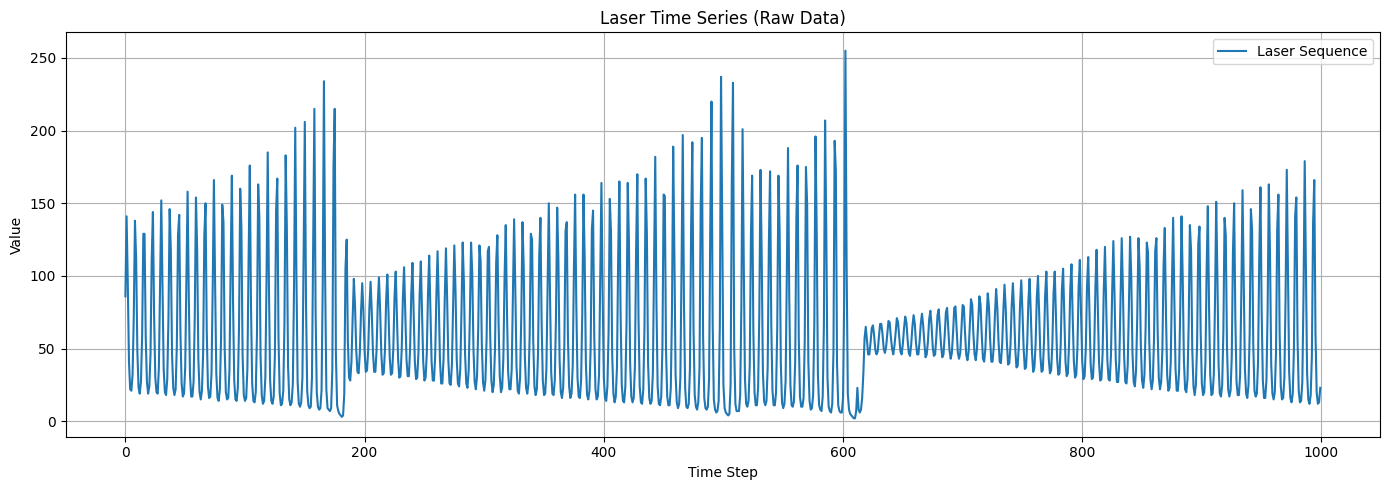

In [56]:
plt.figure(figsize=(14, 5))
plt.plot(x, label='Laser Sequence')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Laser Time Series (Raw Data)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [57]:
# Gaussian normalization for better training
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x.reshape(-1, 1)).flatten()
x_test_scaled = scaler.transform(x_test.reshape(-1, 1)).flatten()

In [50]:
# make sequences of training data of length k+1,
# where k is the number of training instances and the k+1th instance is the test instance (iterative prediction)

def create_sequences(data, k, shuffle=True):
    sequences = []
    for i in range(len(data) - k):
        seq = data[i:i + k + 1]  # total length = k+1
        sequences.append((seq[:-1], seq[-1]))  # first k as X, last as y

    if shuffle:
        random.shuffle(sequences)

    X, y = zip(*sequences)
    return np.array(X), np.array(y)


In [ ]:
# Hyperparameter grid search with L2 regularization - Initialization

mlp_unit_combinations = list(itertools.permutations([16, 32, 64], 3))
mlp_lr_grid      = [0.003, 0.0005, 0.0001]
mlp_activation   = ['relu', 'tanh']
mlp_l2_grid = [1e-6, 1e-5, 1e-4, 5e-5]
k_values         = range(20, 100, 5)

mlp_grid = list(itertools.product(
    k_values,
    mlp_unit_combinations,
    mlp_lr_grid,
    mlp_activation,
    mlp_l2_grid
))

random.seed(42)
sampled_mlp_grid = random.sample(mlp_grid, k=50)


In [51]:
def build_mlp(input_dim, layer_sizes, activation, lr, l2_strength):
    model = Sequential()
    model.add(keras.Input(shape=(input_dim,)))

    for units in layer_sizes:
        model.add(Dense(units, activation=activation,
                        kernel_regularizer=regularizers.l2(l2_strength)))

    model.add(Dense(1))  # Output layer
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='mse')
    return model


In [ ]:
# grid search for best hyperparameter combination

best_combo = None
best_score = float('inf')

n_splits = 5
for (k, layer_sizes, lr, activation, l2_strength) in sampled_mlp_grid:
    X_all, y_all = create_sequences(x_scaled, k, shuffle=True)

    kf = KFold(n_splits=n_splits, shuffle=True)
    fold_mse_scores = []

    for train_idx, val_idx in kf.split(X_all):
        X_tr, X_val = X_all[train_idx], X_all[val_idx]
        y_tr, y_val = y_all[train_idx], y_all[val_idx]

        model = build_mlp(X_all.shape[1], layer_sizes, activation, lr, l2_strength)
        model.fit(X_tr, y_tr, epochs=20, verbose=0)
        mse = model.evaluate(X_val, y_val, verbose=0)
        fold_mse_scores.append(mse)

    avg_mse = np.mean(fold_mse_scores)
    print(f"{k=}, {layer_sizes=}, {lr=:.0e}, {activation=}, {l2_strength=:.4f}, avg_mse={avg_mse:.4f}")

    if avg_mse < best_score:
        best_score = avg_mse
        best_combo = (k, layer_sizes, lr, activation, l2_strength)

print("\nBest MLP:", best_combo, "->", best_score)


k=35, layer_sizes=(16, 64, 32), lr=3e-03, activation='relu', l2_strength=0.0000, avg_mse=0.0892
k=20, layer_sizes=(64, 16, 32), lr=3e-03, activation='tanh', l2_strength=0.0001, avg_mse=0.0683
k=55, layer_sizes=(64, 16, 32), lr=1e-04, activation='tanh', l2_strength=0.0001, avg_mse=0.2589
k=50, layer_sizes=(64, 32, 16), lr=1e-04, activation='relu', l2_strength=0.0001, avg_mse=0.2147
k=50, layer_sizes=(32, 16, 64), lr=3e-03, activation='relu', l2_strength=0.0001, avg_mse=0.0943
k=35, layer_sizes=(64, 32, 16), lr=1e-04, activation='relu', l2_strength=0.0001, avg_mse=0.2541
k=30, layer_sizes=(64, 32, 16), lr=5e-04, activation='relu', l2_strength=0.0001, avg_mse=0.1373
k=95, layer_sizes=(32, 64, 16), lr=3e-03, activation='relu', l2_strength=0.0000, avg_mse=0.1267
k=30, layer_sizes=(32, 16, 64), lr=1e-04, activation='tanh', l2_strength=0.0000, avg_mse=0.2669
k=80, layer_sizes=(16, 32, 64), lr=3e-03, activation='relu', l2_strength=0.0000, avg_mse=0.1152
k=20, layer_sizes=(64, 32, 16), lr=5e-04

In [52]:
best_k, layer_sizes, lr, activation, l2_strength = (20, (64, 32, 16), 0.003, 'relu', 0.0001)

## 5fold Cross-Validation

Data shape: (980, 20)

--- Training fold 1 ---
Fold 1 - Training Loss (MSE): 0.0131
Fold 1 - Training MAE: 0.0357
Fold 1 - Validation Loss (MSE): 0.0391
Fold 1 - Validation MAE: 0.0563


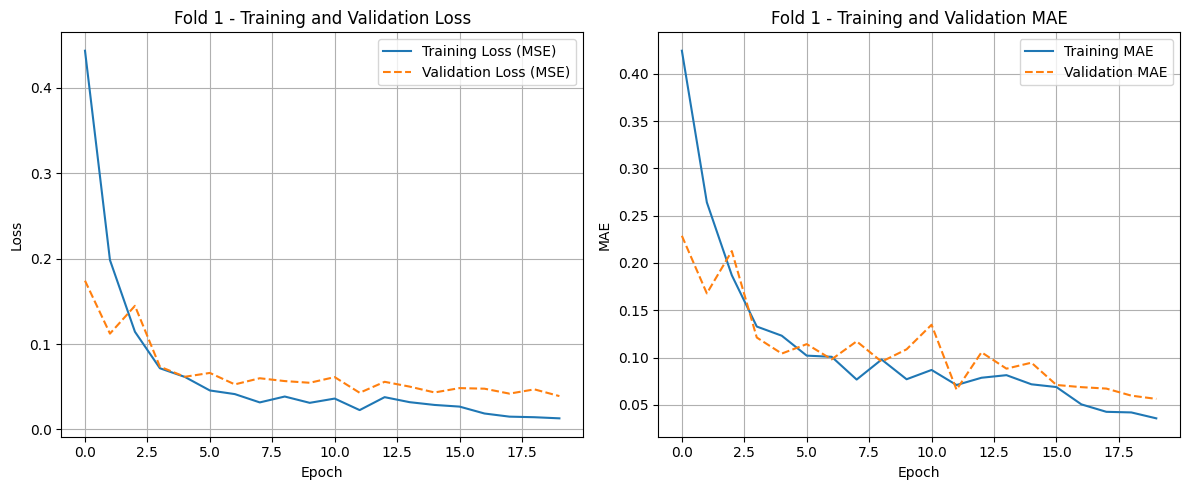


--- Training fold 2 ---
Fold 2 - Training Loss (MSE): 0.0109
Fold 2 - Training MAE: 0.0314
Fold 2 - Validation Loss (MSE): 0.0690
Fold 2 - Validation MAE: 0.0675


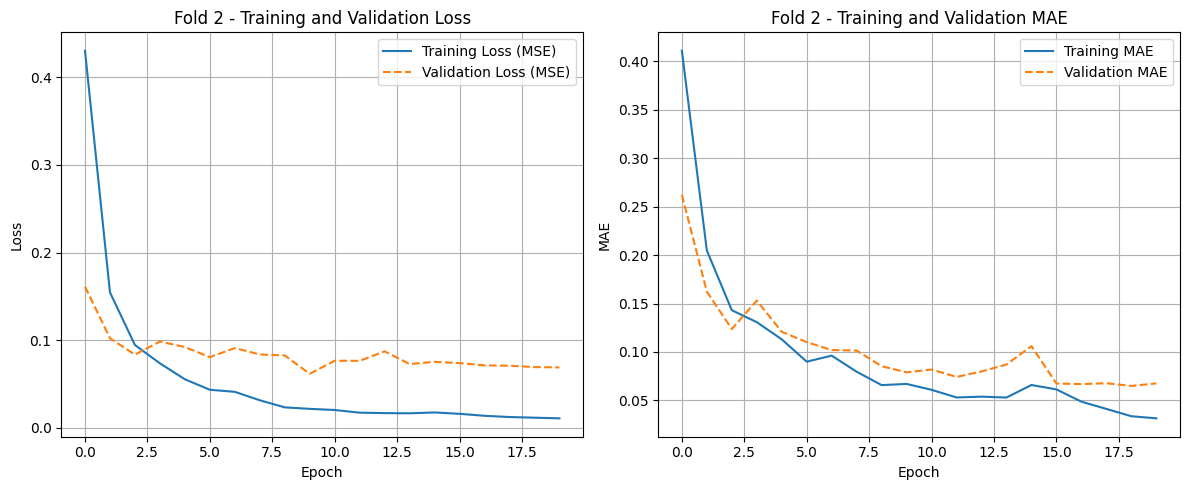


--- Training fold 3 ---
Fold 3 - Training Loss (MSE): 0.0255
Fold 3 - Training MAE: 0.0586
Fold 3 - Validation Loss (MSE): 0.0648
Fold 3 - Validation MAE: 0.0891


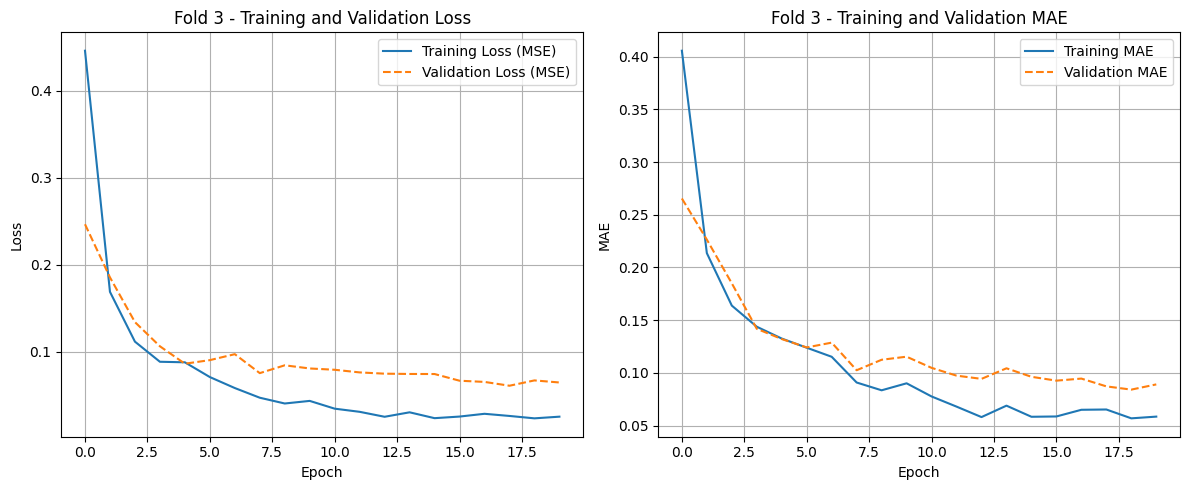


--- Training fold 4 ---
Fold 4 - Training Loss (MSE): 0.0134
Fold 4 - Training MAE: 0.0413
Fold 4 - Validation Loss (MSE): 0.0730
Fold 4 - Validation MAE: 0.0772


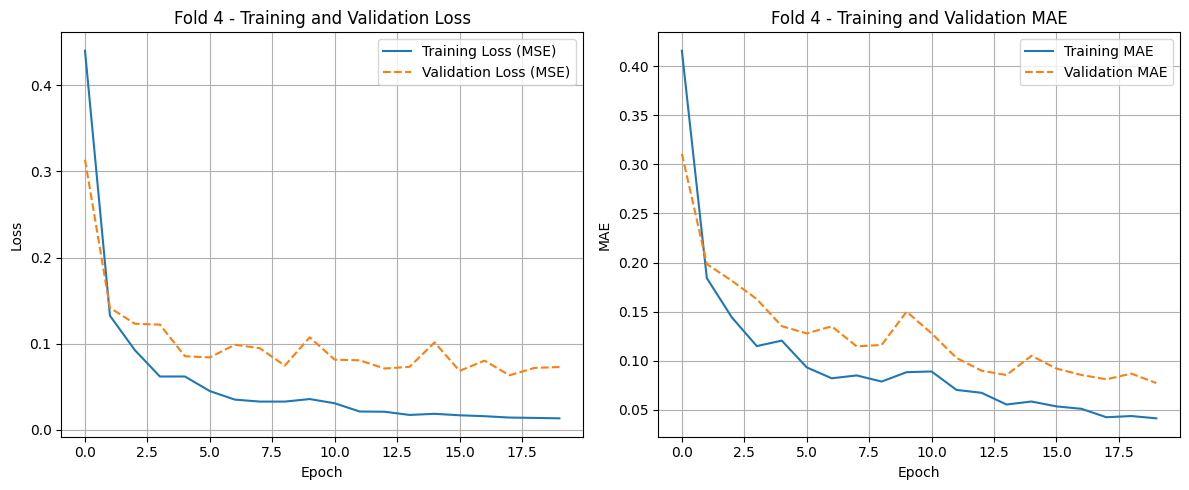


--- Training fold 5 ---
Fold 5 - Training Loss (MSE): 0.0120
Fold 5 - Training MAE: 0.0377
Fold 5 - Validation Loss (MSE): 0.0565
Fold 5 - Validation MAE: 0.0689


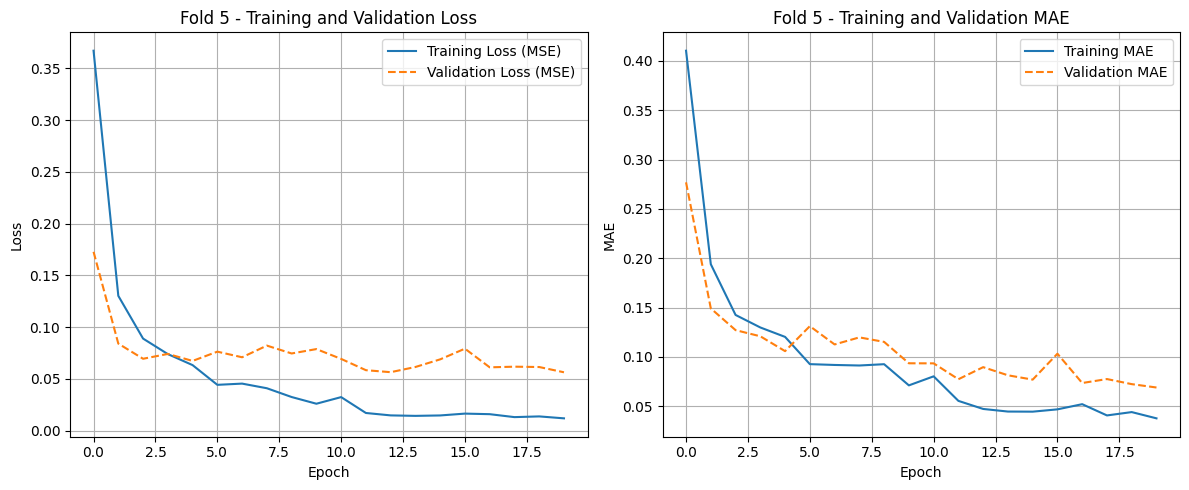


=== Average Results Across All Folds ===
Average Training Loss (MSE): 0.0150
Average Training MAE: 0.0409
Average Validation Loss (MSE): 0.0605
Average Validation MAE: 0.0718


In [ ]:
best_k, layer_sizes, lr, activation, l2_strength = (20, (64, 32, 16), 0.003, 'relu', 0.0001)
X, y = create_sequences(x_scaled, best_k)
print("Data shape:", X.shape)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

losses = []
maes = []
val_losses = []
val_maes = []
models = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n--- Training fold {fold + 1} ---")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Build model using L2 regularization
    model = build_mlp(
        input_dim=X.shape[1],
        layer_sizes=layer_sizes,
        activation=activation,
        lr=lr,
        l2_strength=l2_strength
    )

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=[MeanAbsoluteError()]
    )

    history = model.fit(
        X_train, y_train,
        epochs=20,
        validation_data=(X_val, y_val),
        verbose=0
    )

    models.append(model)

    train_loss = history.history['loss'][-1]
    train_mae = history.history['mean_absolute_error'][-1]
    val_loss = history.history['val_loss'][-1]
    val_mae = history.history['val_mean_absolute_error'][-1]

    losses.append(train_loss)
    maes.append(train_mae)
    val_losses.append(val_loss)
    val_maes.append(val_mae)

    print(f"Fold {fold + 1} - Training Loss (MSE): {train_loss:.4f}")
    print(f"Fold {fold + 1} - Training MAE: {train_mae:.4f}")
    print(f"Fold {fold + 1} - Validation Loss (MSE): {val_loss:.4f}")
    print(f"Fold {fold + 1} - Validation MAE: {val_mae:.4f}")

    # Plot training and validation metrics
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Validation Loss (MSE)', linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Fold {fold + 1} - Training and Validation Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE', linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.title(f"Fold {fold + 1} - Training and Validation MAE")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Average results
avg_train_loss = np.mean(losses)
avg_train_mae = np.mean(maes)
avg_val_loss = np.mean(val_losses)
avg_val_mae = np.mean(val_maes)

print(f"\n=== Average Results Across All Folds ===")
print(f"Average Training Loss (MSE): {avg_train_loss:.4f}")
print(f"Average Training MAE: {avg_train_mae:.4f}")
print(f"Average Validation Loss (MSE): {avg_val_loss:.4f}")
print(f"Average Validation MAE: {avg_val_mae:.4f}")


### 5Fold crossvalidation: MSE vs Lookback

Evaluating k = 1
  --> Mean MSE: 0.6626
Evaluating k = 25
  --> Mean MSE: 0.0844
Evaluating k = 50
  --> Mean MSE: 0.1139
Evaluating k = 75
  --> Mean MSE: 0.1641
Evaluating k = 100
  --> Mean MSE: 0.1645
Evaluating k = 125
  --> Mean MSE: 0.2064
Evaluating k = 150
  --> Mean MSE: 0.2176
Evaluating k = 175
  --> Mean MSE: 0.2156
Evaluating k = 200
  --> Mean MSE: 0.1916

Best k based on cross-validated MSE: 25 (MSE = 0.0844)


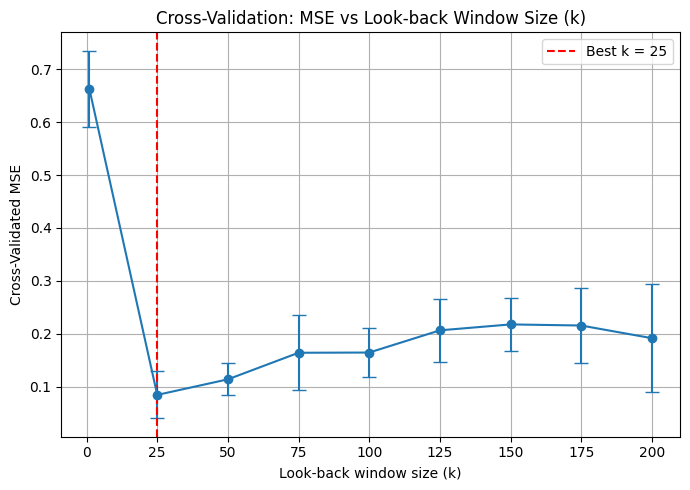

In [97]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

k_values = [1, 25, 50, 75, 100, 125, 150, 175, 200]
k_results = []

_, layer_sizes, lr, activation, l2_strength = best_combo

for k in k_values:
    print(f"Evaluating k = {k}")
    X_all, y_all = create_sequences(x_scaled, k)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    fold_mse = []

    for train_idx, val_idx in kf.split(X_all):
        X_train, X_val = X_all[train_idx], X_all[val_idx]
        y_train, y_val = y_all[train_idx], y_all[val_idx]

        model = build_mlp(
            input_dim=k,
            layer_sizes=layer_sizes,
            activation=activation,
            lr=lr,
            l2_strength=l2_strength
        )

        model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='mse',
            metrics=[MeanAbsoluteError()]
        )

        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, verbose=0)
        val_mse, _ = model.evaluate(X_val, y_val, verbose=0)
        fold_mse.append(val_mse)

    avg_mse = np.mean(fold_mse)
    std_mse = np.std(fold_mse)
    k_results.append((k, avg_mse, std_mse))
    print(f"  --> Mean MSE: {avg_mse:.4f}")

# Find best lookback (k)
best_k_mlp, best_mse, _ = min(k_results, key=lambda x: x[1])
print(f"\nBest k based on cross-validated MSE: {best_k_mlp} (MSE = {best_mse:.4f})")


# plots
k_vals, mean_losses, std_losses = zip(*k_results)
plt.figure(figsize=(7, 5))
plt.errorbar(k_vals, mean_losses, yerr=std_losses, fmt='-o', capsize=5)
plt.axvline(best_k_mlp, color='red', linestyle='--', label=f'Best k = {best_k_mlp}')
plt.xlabel("Look-back window size (k)")
plt.ylabel("Cross-Validated MSE")
plt.title("Cross-Validation: MSE vs Look-back Window Size (k)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Test set evaluation

### 5fold models

In [88]:
# Load best 5fold models
!wget https://raw.githubusercontent.com/antisocialites/Deep-Learning/main/Assignment%201/MLP/Models5-8-L2/L2_mlp_model_fold_5.h5

--2025-05-09 09:40:52--  https://raw.githubusercontent.com/antisocialites/Deep-Learning/main/Assignment%201/MLP/Models5-8-L2/L2_mlp_model_fold_5.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86232 (84K) [application/octet-stream]
Saving to: ‘L2_mlp_model_fold_5.h5.1’

L2_mlp_model_fold_5 100%[===================>]  84.21K  --.-KB/s    in 0.03s   

2025-05-09 09:40:53 (2.65 MB/s) - ‘L2_mlp_model_fold_5.h5.1’ saved [86232/86232]



In [89]:
model_fold5 = load_model('L2_mlp_model_fold_5.h5', compile=False)

In [95]:
best_combo = (20, (64, 32, 16), 0.003, 'relu', 0.0001)

In [90]:
def iterative_mlp_forecast(model, train_set, scaler, lookback, n_steps=500):

    # Start with last `lookback` values from training set
    current_input = train_set[-lookback:].reshape(1, -1)  # shape (1, lookback)
    predictions = []

    for _ in range(n_steps):
        next_val = model.predict(current_input, verbose=0)[0][0]  # extract scalar
        predictions.append(next_val)
        # Update input window (still shape (1, lookback))
        current_input = np.concatenate([current_input[:, 1:], np.array([[next_val]])], axis=1)

    # Inverse transform predictions to original scale
    pred_unscaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

    return pred_unscaled


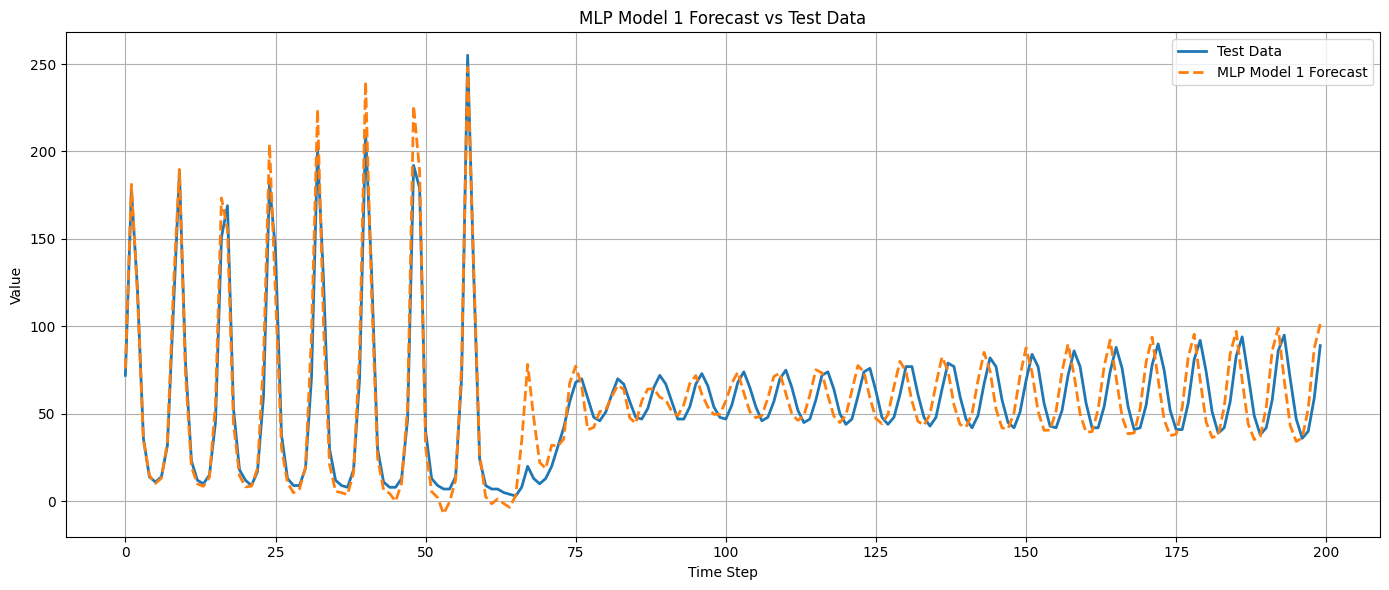

In [93]:
n_forecast_steps = len(x_test_scaled)  # match test set length
predictions = iterative_mlp_forecast(model_fold5, x_scaled, scaler, best_k, n_steps=n_forecast_steps)

# Inverse transform test set for comparison
test_unscaled = scaler.inverse_transform(x_test_scaled.reshape(-1, 1)).flatten()

# Plot predictions vs test data
plt.figure(figsize=(14, 6))
plt.plot(test_unscaled, label='Test Data', linewidth=2)
plt.plot(predictions, label='MLP Model 1 Forecast', linewidth=2, linestyle='--')
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("MLP Model 1 Forecast vs Test Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [92]:
mae_test = mean_absolute_error(test_unscaled, predictions)
mse_test = mean_squared_error(test_unscaled, predictions)

print(f"Test MAE: {mae_test:.4f}")
print(f"Test MSE: {mse_test:.4f}")

Test MAE: 11.3034
Test MSE: 207.0489


### Next 200 points prediction


Predicting next 200 steps with model 1


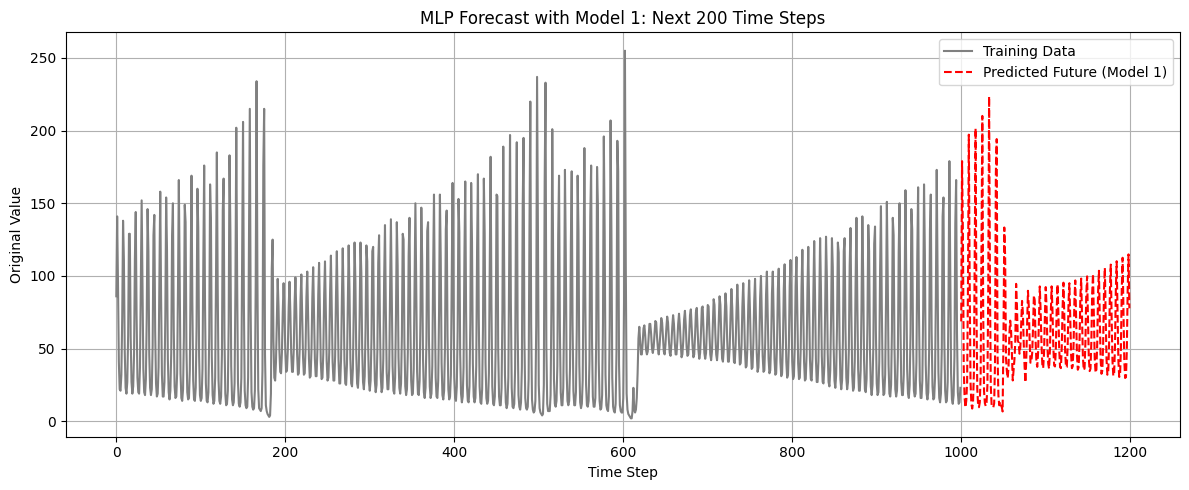


Predicting next 200 steps with model 2


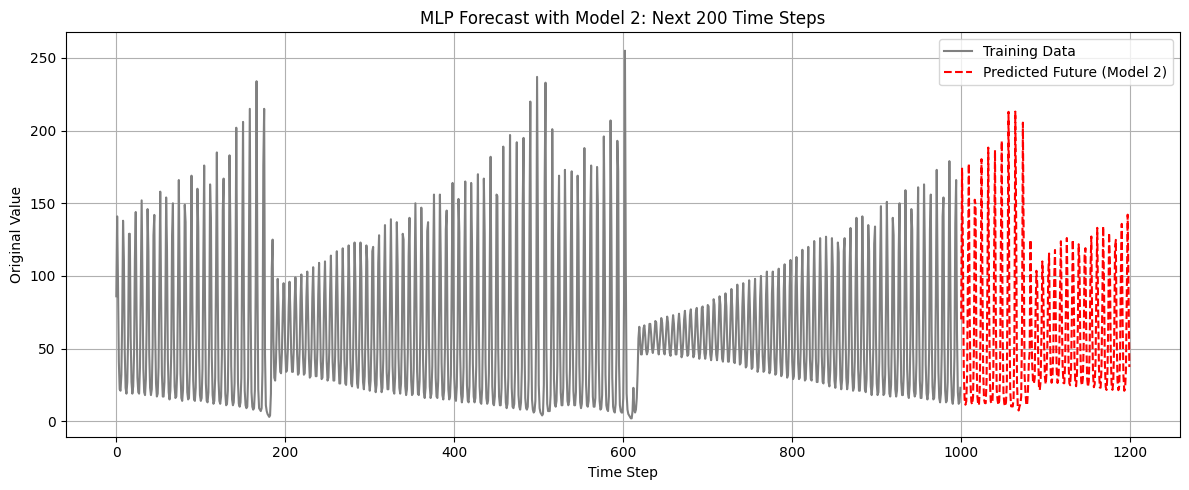


Predicting next 200 steps with model 3


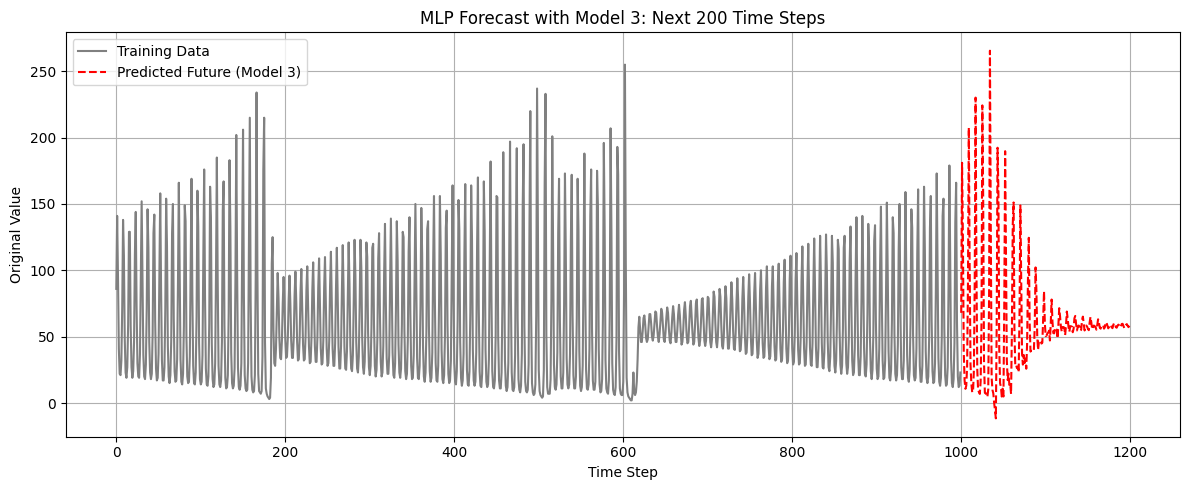


Predicting next 200 steps with model 4


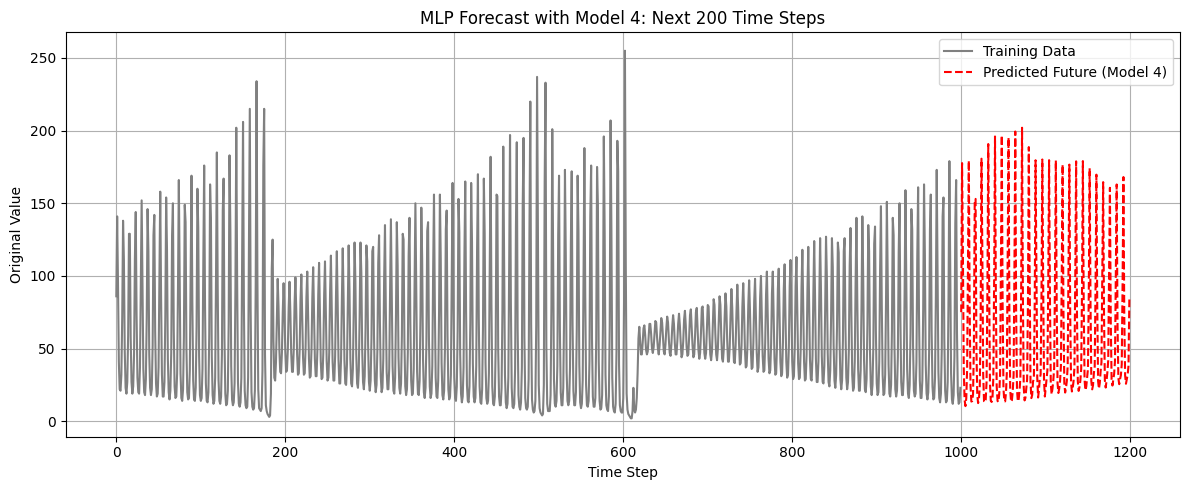


Predicting next 200 steps with model 5


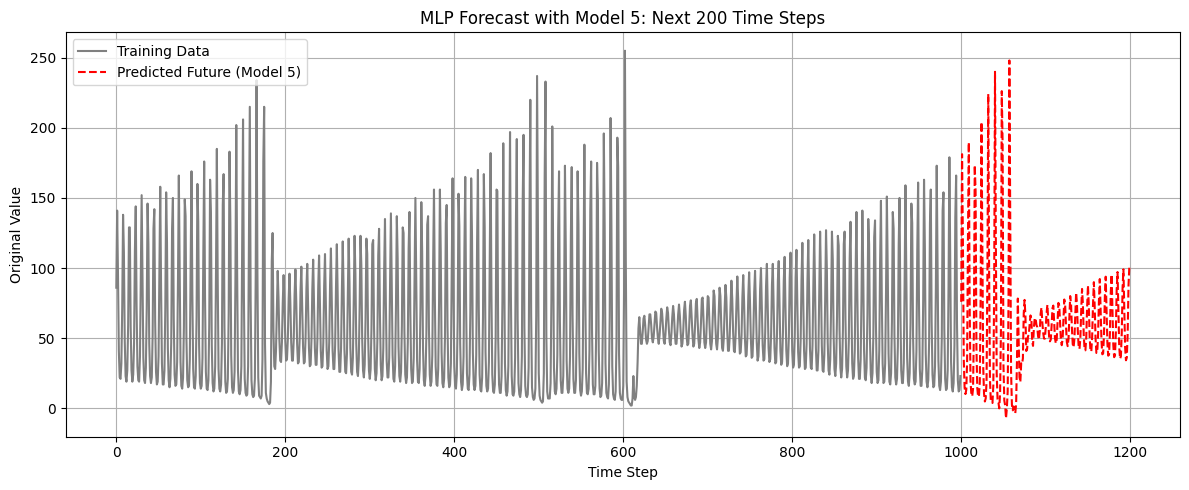

In [ ]:
# test set isn't used, just to make the create_sequences work properly
test_set = x_scaled[:200]
train_set = x_scaled

X_train, y_train = create_sequences(train_set, best_k)

# scale data back for the full training data for plotting
train_original = scaler.inverse_transform(train_set.reshape(-1, 1)).flatten()
train_len = len(train_set)

# plot for all trained models
for i, model in enumerate(models):
    print(f"\nPredicting next 200 steps with model {i + 1}")

    # Forecast using the i-th model
    mlp_preds = iterative_mlp_forecast(model, train_set, scaler, best_k, n_steps=200)

    # timeline of predicted points
    prediction_timeline = np.arange(train_len, train_len + len(mlp_preds))

    plt.figure(figsize=(12, 5))
    plt.plot(train_original, label='Training Data', color='gray')
    plt.plot(prediction_timeline, mlp_preds, label=f'Predicted Future (Model {i + 1})', color='red', linestyle='--')
    plt.title(f"MLP Forecast with Model {i + 1}: Next 200 Time Steps")
    plt.xlabel("Time Step")
    plt.ylabel("Original Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Trained on full dataset

Full training data shape: (980, 20)
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8814 - mean_absolute_error: 0.6209
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1686 - mean_absolute_error: 0.2307
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1013 - mean_absolute_error: 0.1551
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0839 - mean_absolute_error: 0.1295
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0709 - mean_absolute_error: 0.1165
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0639 - mean_absolute_error: 0.1145
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0571 - mean_absolute_error: 0.1100
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0534 - mean_absolute_error: 0.1076
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0524 - mean_absolute_error: 0.1085
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0468 - mean_absolute_error: 0.1017
Epoch 11/20
3

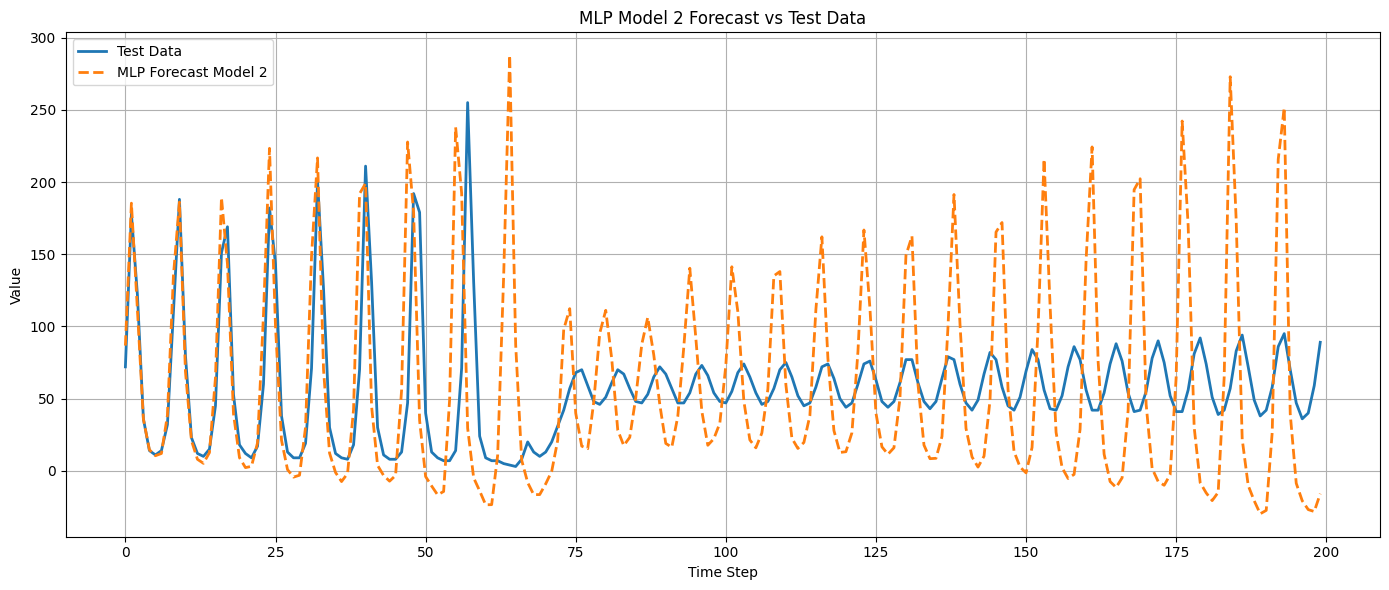

In [84]:
# Build and train model on full training set
X_train_full, y_train_full = create_sequences(x_scaled, best_k)
print("Full training data shape:", X_train_full.shape)

model = build_mlp(
    input_dim=X_train_full.shape[1],
    layer_sizes=layer_sizes,
    activation=activation,
    lr=lr,
    l2_strength=l2_strength
)

model.compile(
    optimizer=Adam(learning_rate=lr),
    loss='mse',
    metrics=[MeanAbsoluteError()]
)

history = model.fit(
    X_train_full, y_train_full,
    epochs=20,
    verbose=1  # set to 0 if you prefer silent training
)

# Use iterative forecasting to predict on test set
n_forecast_steps = len(x_test_scaled)  # match test set length
predictions = iterative_mlp_forecast(model, x_scaled, scaler, best_k, n_steps=n_forecast_steps)

# Inverse transform test set for comparison
test_unscaled = scaler.inverse_transform(x_test_scaled.reshape(-1, 1)).flatten()

# Plot predictions vs actuals
plt.figure(figsize=(14, 6))
plt.plot(test_unscaled, label='Test Data', linewidth=2)
plt.plot(predictions, label='MLP Forecast Model 2', linewidth=2, linestyle='--')
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("MLP Model 2 Forecast vs Test Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [85]:
# evaluation metrics

mae_test = mean_absolute_error(test_unscaled, predictions)
mse_test = mean_squared_error(test_unscaled, predictions)

print(f"Test MAE: {mae_test:.4f}")
print(f"Test MSE: {mse_test:.4f}")


Test MAE: 50.1740
Test MSE: 4803.5312


### Observing differences within same model

Full training data shape: (980, 20)

--- Run 1 ---
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5806 - mean_absolute_error: 0.4382
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1607 - mean_absolute_error: 0.2204
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1005 - mean_absolute_error: 0.1510
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0745 - mean_absolute_error: 0.1232
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0592 - mean_absolute_error: 0.1052
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0469 - mean_absolute_error: 0.0856
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0408 - mean_absolute_error: 0.0717
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0370 - mean_absolute_error: 0.0687
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0348 - mean_absolute_error: 0.0669
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0318 - mean_absolute_error: 0.063

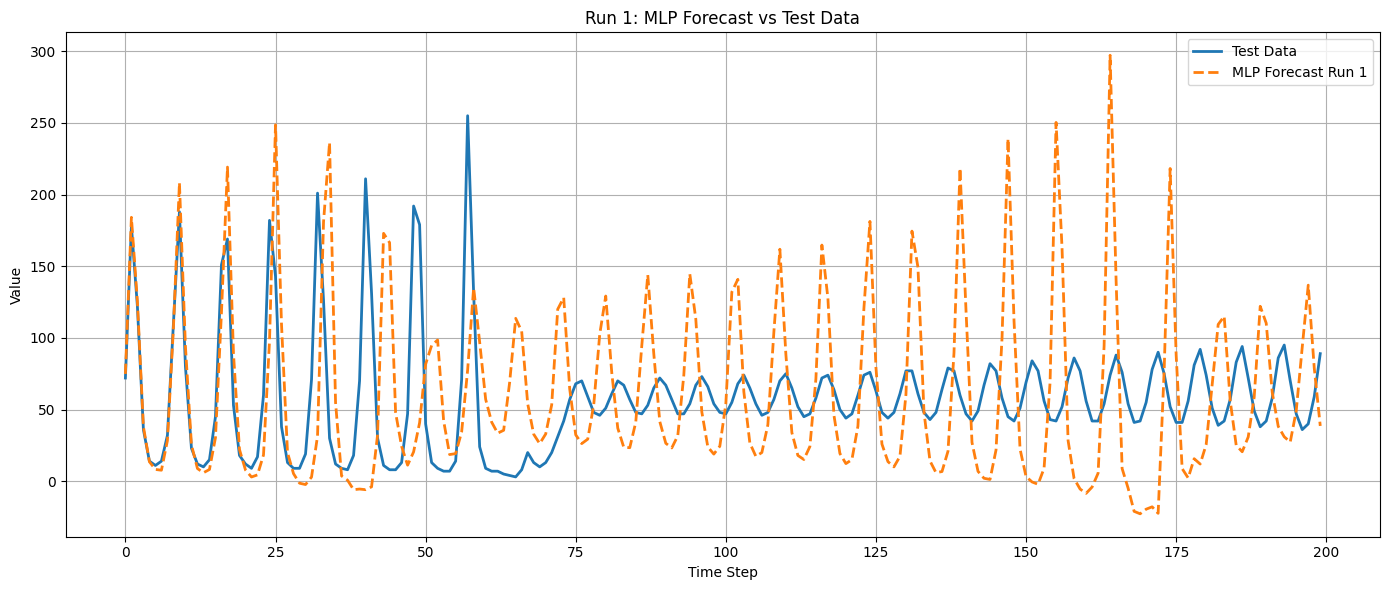


--- Run 2 ---
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5820 - mean_absolute_error: 0.5129
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1248 - mean_absolute_error: 0.2039
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0742 - mean_absolute_error: 0.1236
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0577 - mean_absolute_error: 0.1137
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0486 - mean_absolute_error: 0.0936
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0371 - mean_absolute_error: 0.0755
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0332 - mean_absolute_error: 0.0719
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0366 - mean_absolute_error: 0.0738
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0337 - mean_absolute_error: 0.0740
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0266 - mean_absolute_error: 0.0614
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━

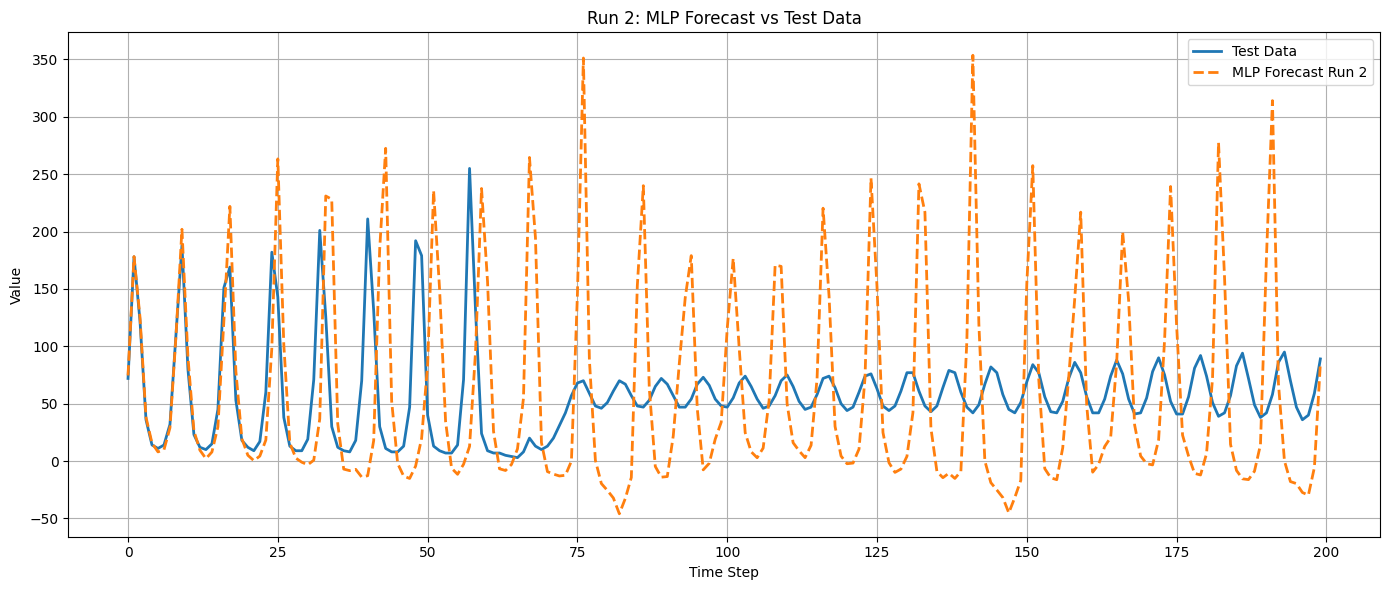


--- Run 3 ---
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5726 - mean_absolute_error: 0.5500
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1472 - mean_absolute_error: 0.2060
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0958 - mean_absolute_error: 0.1451
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0665 - mean_absolute_error: 0.1095
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0566 - mean_absolute_error: 0.1018
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0435 - mean_absolute_error: 0.0840
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0351 - mean_absolute_error: 0.0698
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0340 - mean_absolute_error: 0.0686
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0334 - mean_absolute_error: 0.0624
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0296 - mean_absolute_error: 0.0638
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━

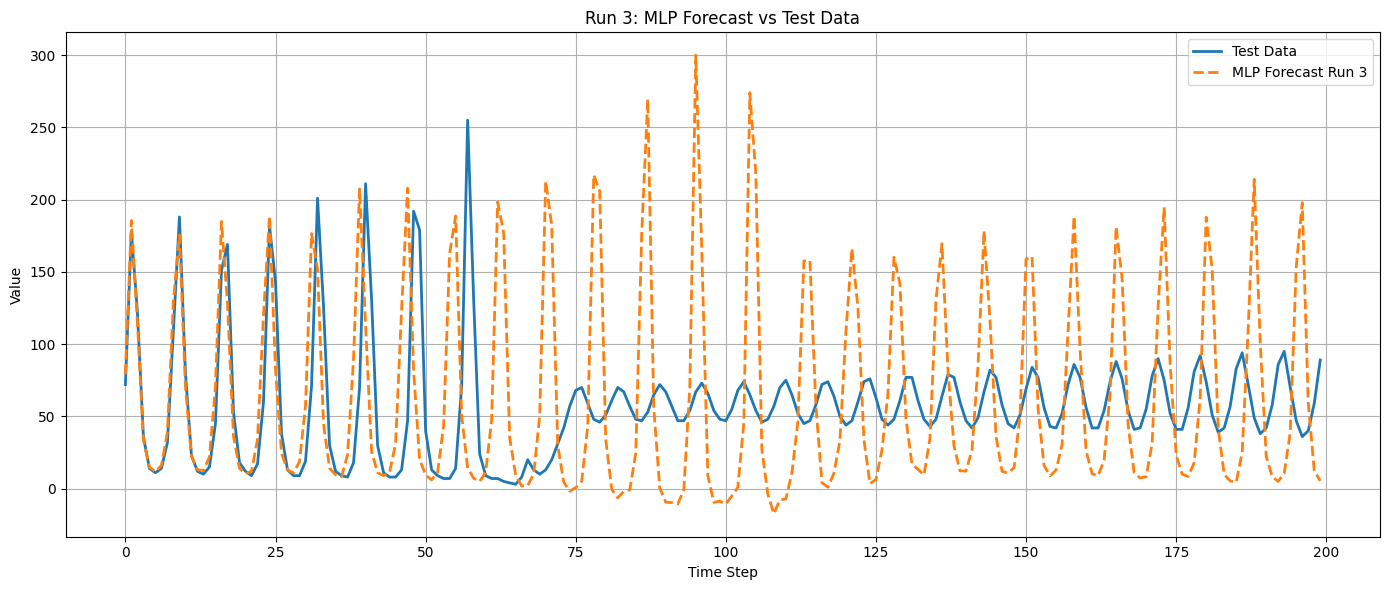


--- Run 4 ---
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6224 - mean_absolute_error: 0.4788
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1692 - mean_absolute_error: 0.2226
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0908 - mean_absolute_error: 0.1311
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0622 - mean_absolute_error: 0.1072
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0505 - mean_absolute_error: 0.0902
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0426 - mean_absolute_error: 0.0814
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0359 - mean_absolute_error: 0.0738
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0372 - mean_absolute_error: 0.0725
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0352 - mean_absolute_error: 0.0714
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0289 - mean_absolute_error: 0.0643
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━

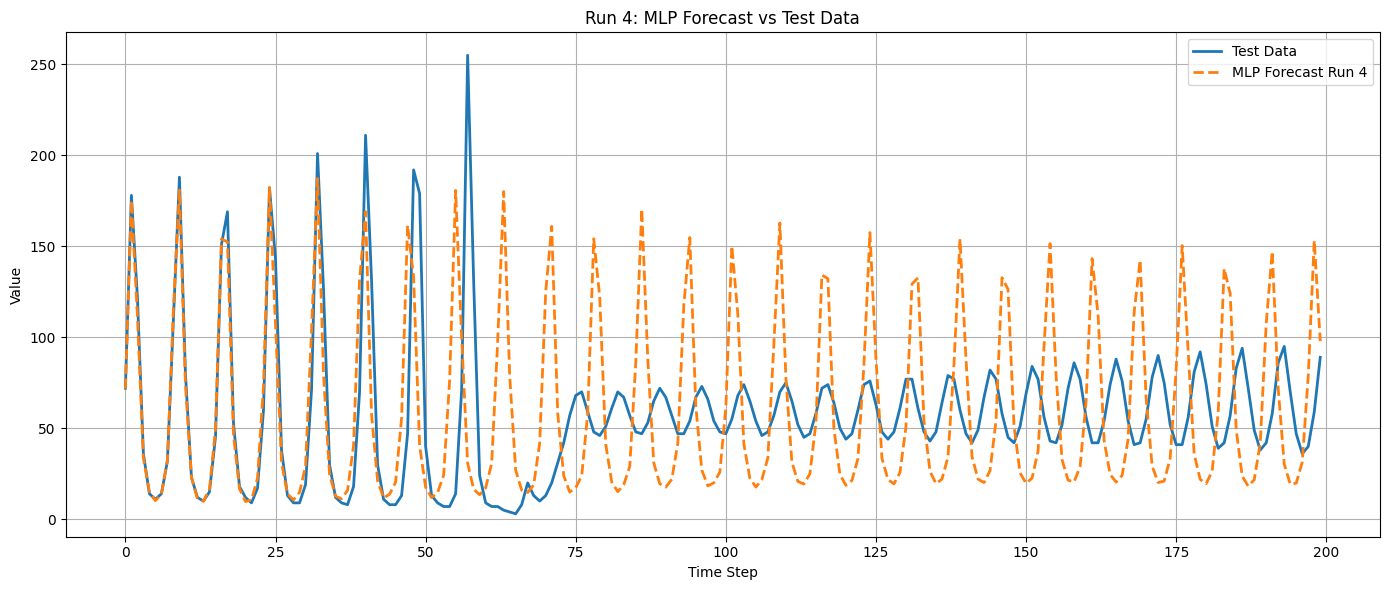


--- Run 5 ---
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6139 - mean_absolute_error: 0.5816
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1277 - mean_absolute_error: 0.1909
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0816 - mean_absolute_error: 0.1238
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0671 - mean_absolute_error: 0.1163
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0551 - mean_absolute_error: 0.1087
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0470 - mean_absolute_error: 0.0945
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0412 - mean_absolute_error: 0.0854
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0362 - mean_absolute_error: 0.0805
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0337 - mean_absolute_error: 0.0747
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0324 - mean_absolute_error: 0.0703
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━

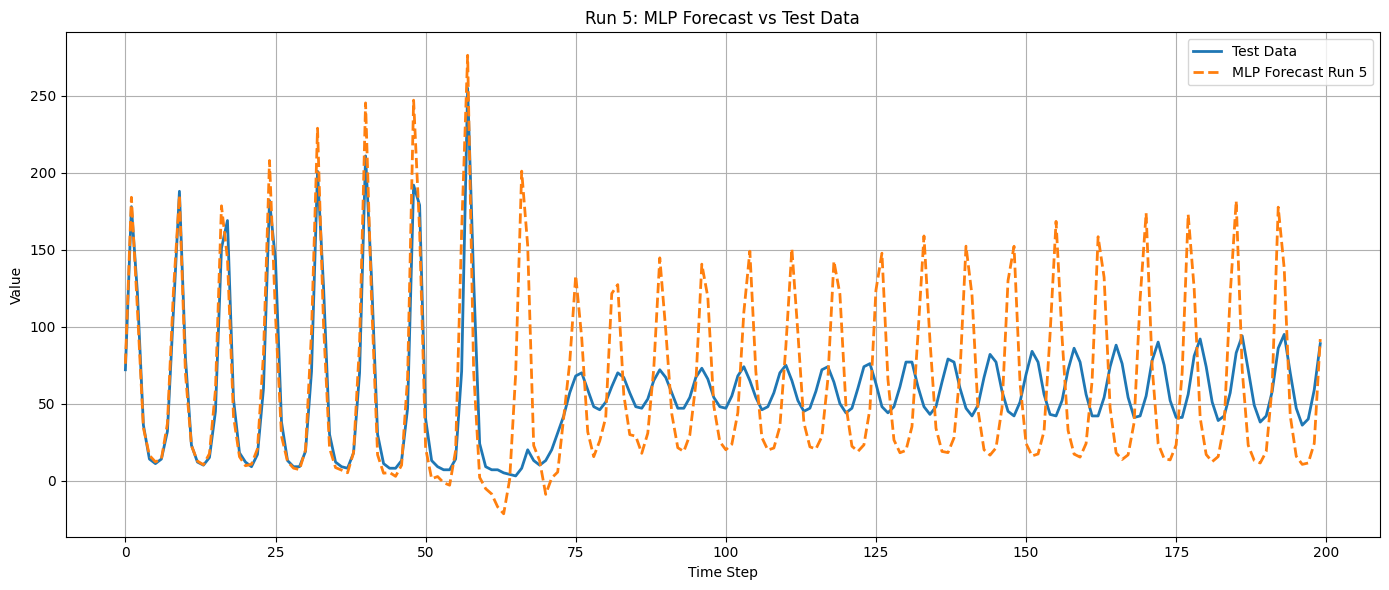


--- Run 6 ---
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4271 - mean_absolute_error: 0.4389
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1295 - mean_absolute_error: 0.2009
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0867 - mean_absolute_error: 0.1448
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0571 - mean_absolute_error: 0.1142
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0405 - mean_absolute_error: 0.0904
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0353 - mean_absolute_error: 0.0796
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0300 - mean_absolute_error: 0.0730
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0266 - mean_absolute_error: 0.0689
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0257 - mean_absolute_error: 0.0665
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0281 - mean_absolute_error: 0.0703
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━

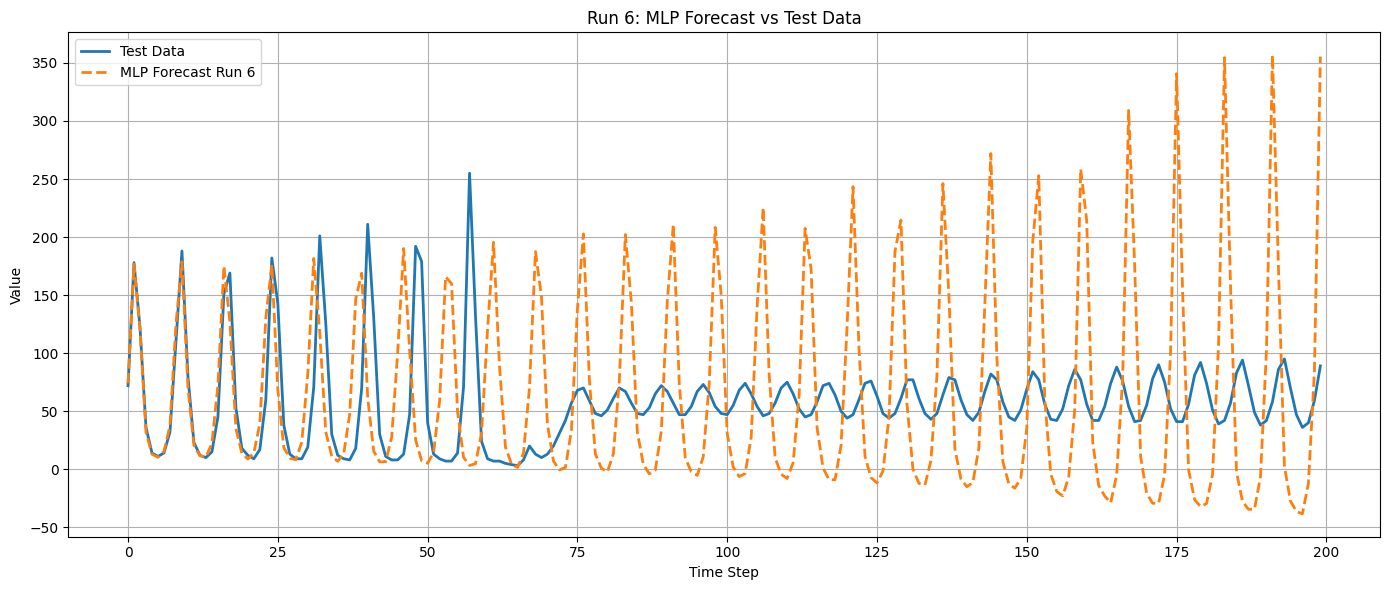


--- Run 7 ---
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5194 - mean_absolute_error: 0.4606
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0818 - mean_absolute_error: 0.1484
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0554 - mean_absolute_error: 0.1058
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0482 - mean_absolute_error: 0.0901
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0392 - mean_absolute_error: 0.0770
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0371 - mean_absolute_error: 0.0712
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0358 - mean_absolute_error: 0.0715
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0339 - mean_absolute_error: 0.0684
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0297 - mean_absolute_error: 0.0623
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0312 - mean_absolute_error: 0.0649
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━

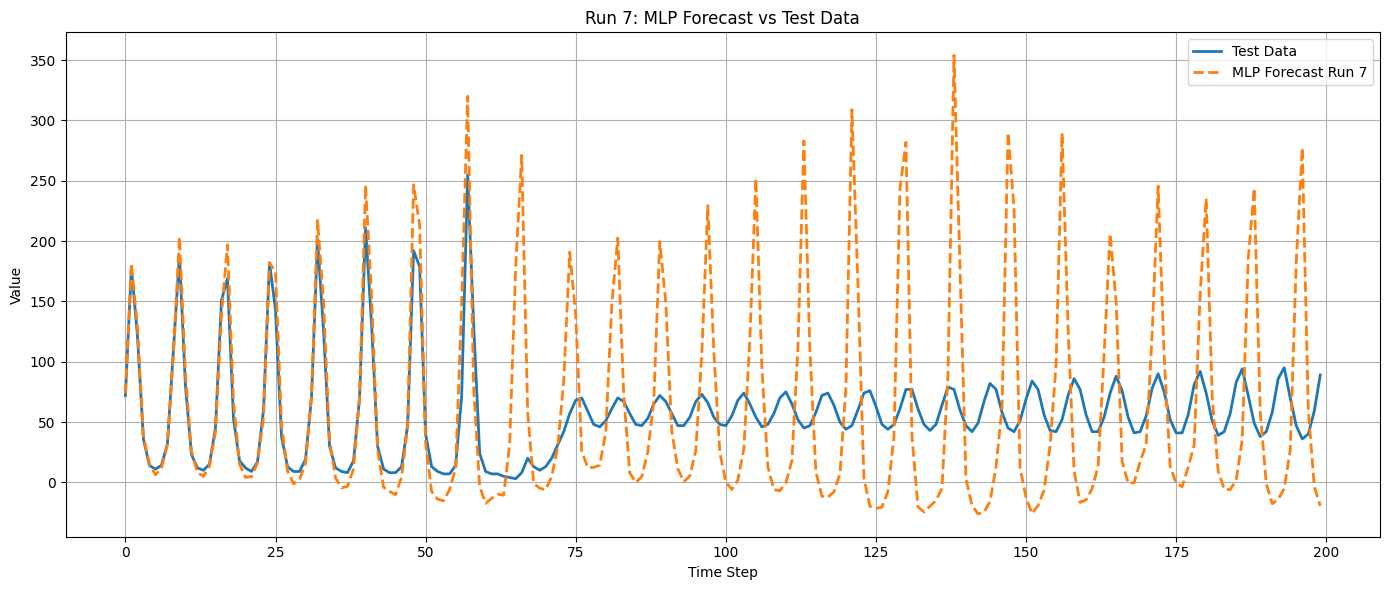


--- Run 8 ---
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5198 - mean_absolute_error: 0.4888
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1090 - mean_absolute_error: 0.1739
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0764 - mean_absolute_error: 0.1319
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0574 - mean_absolute_error: 0.1104
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0474 - mean_absolute_error: 0.0995
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0401 - mean_absolute_error: 0.0880
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0372 - mean_absolute_error: 0.0816
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0358 - mean_absolute_error: 0.0753
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0351 - mean_absolute_error: 0.0733
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0339 - mean_absolute_error: 0.0704
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━

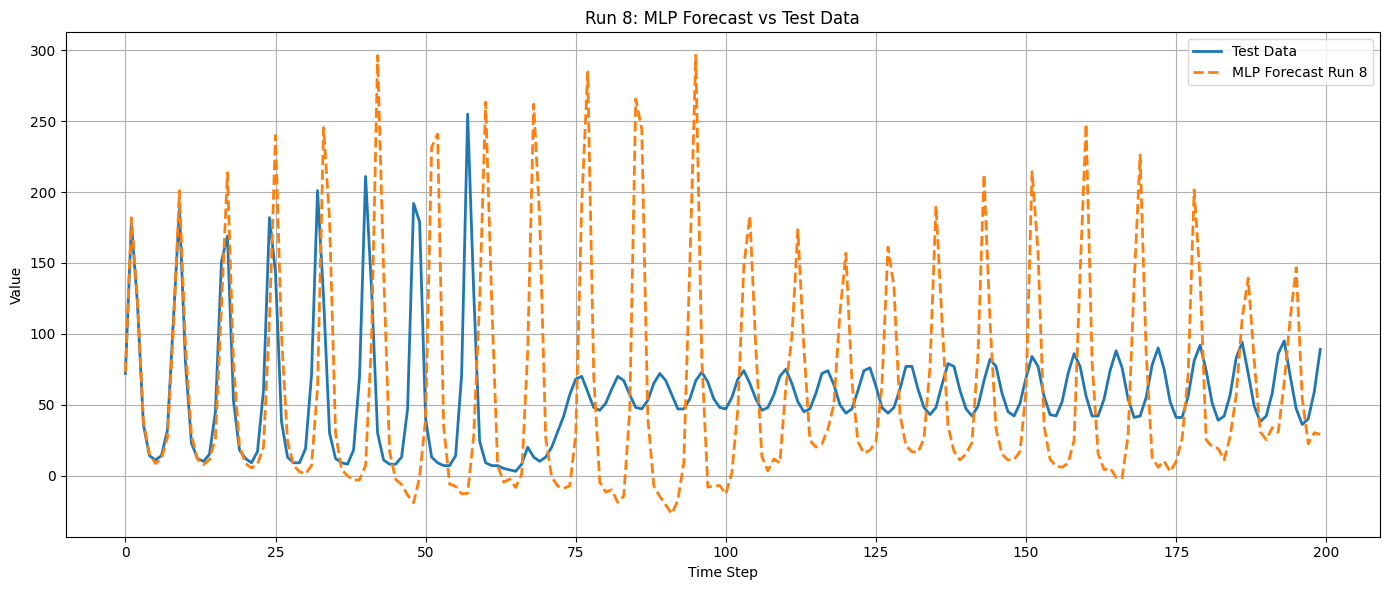


--- Run 9 ---
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4588 - mean_absolute_error: 0.4076
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1296 - mean_absolute_error: 0.1973
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0735 - mean_absolute_error: 0.1288
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0575 - mean_absolute_error: 0.1086
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0483 - mean_absolute_error: 0.0942
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0386 - mean_absolute_error: 0.0803
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0350 - mean_absolute_error: 0.0761
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0294 - mean_absolute_error: 0.0672
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0278 - mean_absolute_error: 0.0654
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0257 - mean_absolute_error: 0.0606
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━

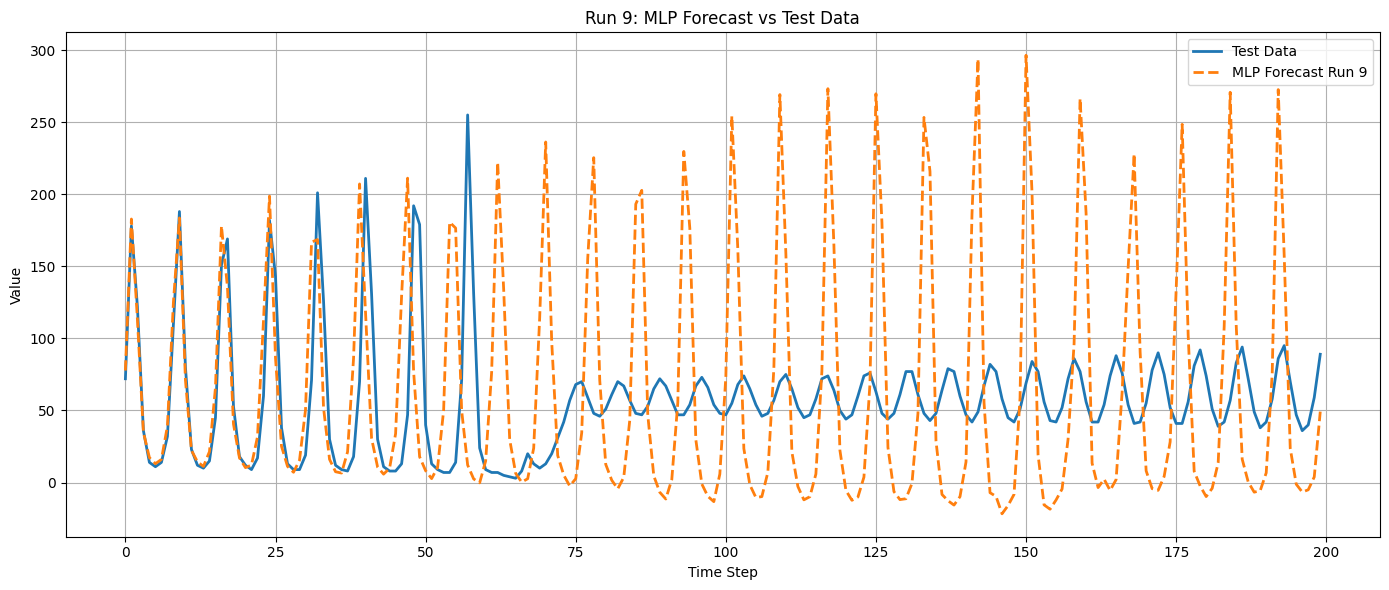


--- Run 10 ---
Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6309 - mean_absolute_error: 0.5753
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1101 - mean_absolute_error: 0.1746
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0670 - mean_absolute_error: 0.1211
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0501 - mean_absolute_error: 0.1033
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0412 - mean_absolute_error: 0.0847
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0322 - mean_absolute_error: 0.0750
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0295 - mean_absolute_error: 0.0686
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0235 - mean_absolute_error: 0.0572
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0219 - mean_absolute_error: 0.0532
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0187 - mean_absolute_error: 0.0476
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━

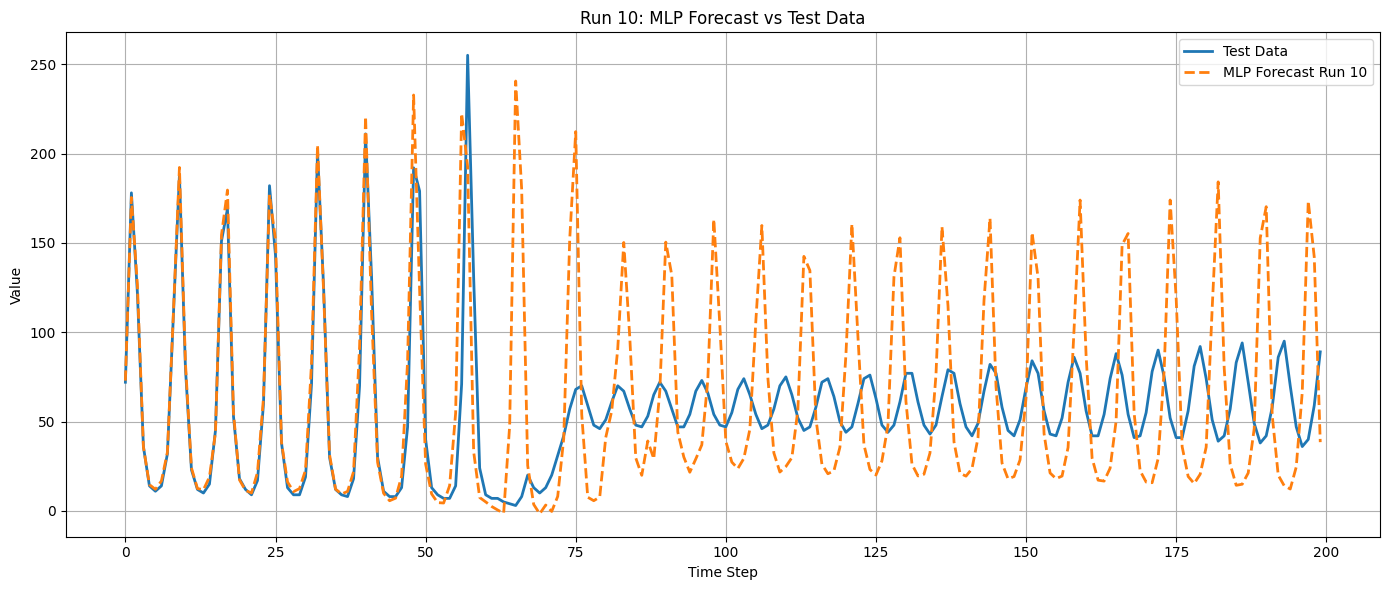


=== Summary Across 10 Runs ===
Average MAE: 53.1122 ± 12.8470
Average MSE: 5614.2816 ± 2340.7483


In [87]:
import os
from tensorflow.keras.models import save_model

n_runs = 10
mae_scores = []
mse_scores = []


X_train_full, y_train_full = create_sequences(x_scaled, best_k)
print("Full training data shape:", X_train_full.shape)

# unscale test set for plotting
test_unscaled = scaler.inverse_transform(x_test_scaled.reshape(-1, 1)).flatten()
n_forecast_steps = len(x_test_scaled)

for i in range(n_runs):
    print(f"\n--- Run {i + 1} ---")

    # building/training model
    model = build_mlp(
        input_dim=X_train_full.shape[1],
        layer_sizes=layer_sizes,
        activation=activation,
        lr=lr,
        l2_strength=l2_strength
    )

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=[MeanAbsoluteError()]
    )

    # Train model
    history = model.fit(
        X_train_full, y_train_full,
        epochs=20,
        verbose=1
    )

    # Forecast
    predictions = iterative_mlp_forecast(model, x_scaled, scaler, best_k, n_steps=n_forecast_steps)

    # Save model
    save_model(model, f"model_{i}.keras")

    # Compute and store metrics
    mae = mean_absolute_error(test_unscaled, predictions)
    mse = mean_squared_error(test_unscaled, predictions)
    mae_scores.append(mae)
    mse_scores.append(mse)

    print(f"Test MAE: {mae:.4f}")
    print(f"Test MSE: {mse:.4f}")

    # Plot predictions vs actuals
    plt.figure(figsize=(14, 6))
    plt.plot(test_unscaled, label='Test Data', linewidth=2)
    plt.plot(predictions, label=f'MLP Forecast Run {i+1}', linewidth=2, linestyle='--')
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title(f"Run {i+1}: MLP Forecast vs Test Data")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Summary stats
print("\n=== Summary Across 10 Runs ===")
print(f"Average MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"Average MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
